In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('default of credit card clients.xls',header = 1)

# Data Preparation

In [3]:
df_temp = df.copy()

In [4]:
print(df_temp.shape)
df_temp.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df_temp.columns.values

array(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month'], dtype=object)

In [6]:
months_info = [
    ('Sep', 'PAY_0', 'BILL_AMT1', 'PAY_AMT1'),
    ('Aug', 'PAY_2', 'BILL_AMT2', 'PAY_AMT2'),
    ('Jul', 'PAY_3', 'BILL_AMT3', 'PAY_AMT3'),
    ('Jun', 'PAY_4', 'BILL_AMT4', 'PAY_AMT4'),
    ('May', 'PAY_5', 'BILL_AMT5', 'PAY_AMT5'),
    ('Apr', 'PAY_6', 'BILL_AMT6', 'PAY_AMT6'),
]

In [7]:
def generate_monthly_features(df,months_info):
    
    dfs = []
    
    for month,pay_col,bill_col,pay_amt_col in months_info:
        temp_df = df[['ID','LIMIT_BAL',pay_col,bill_col,pay_amt_col]].copy()
        
        temp_df[f'utilization_ratio {month}'] = temp_df[bill_col]/temp_df['LIMIT_BAL']

        temp_df[f'Paid {month}'] = np.where(temp_df[pay_amt_col] > 0, 1,0)

        temp_df[f'Delinquent {month}'] = np.where(temp_df[pay_col] >= 1, 1,0)
        
        keep_cols = ['ID',f'utilization_ratio {month}',f'Paid {month}',f'Delinquent {month}']
        
        dfs.append(temp_df[keep_cols])
    
    for temp_df in dfs:
        df = pd.merge(df,temp_df,on='ID',how='inner')
            
    return df

In [8]:
df_temp = generate_monthly_features(df_temp, months_info)

In [9]:
df_temp.rename(columns={'PAY_0':'PAY_Sep','PAY_2':'PAY_Aug','PAY_3':'PAY_Jul','PAY_4':'PAY_Jun','PAY_5':'PAY_May','PAY_6':'PAY_Apr'},inplace= True)

In [10]:
df_temp.rename(columns={'BILL_AMT1':'BILL_AMT_Sep','BILL_AMT2':'BILL_AMT_Aug','BILL_AMT3':'BILL_AMT_Jul','BILL_AMT4':'BILL_AMT_Jun','BILL_AMT5':'BILL_AMT_May','BILL_AMT6':'BILL_AMT_Apr'},inplace= True)

In [11]:
df_temp.rename(columns={'PAY_AMT1':'PAY_AMT_Sep','PAY_AMT2':'PAY_AMT_Aug','PAY_AMT3':'PAY_AMT_Jul','PAY_AMT4':'PAY_AMT_Jun','PAY_AMT5':'PAY_AMT_May','PAY_AMT6':'PAY_AMT_Apr'},inplace= True)

In [12]:
df_temp.columns.values

array(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_Sep', 'PAY_Aug', 'PAY_Jul', 'PAY_Jun', 'PAY_May', 'PAY_Apr',
       'BILL_AMT_Sep', 'BILL_AMT_Aug', 'BILL_AMT_Jul', 'BILL_AMT_Jun',
       'BILL_AMT_May', 'BILL_AMT_Apr', 'PAY_AMT_Sep', 'PAY_AMT_Aug',
       'PAY_AMT_Jul', 'PAY_AMT_Jun', 'PAY_AMT_May', 'PAY_AMT_Apr',
       'default payment next month', 'utilization_ratio Sep', 'Paid Sep',
       'Delinquent Sep', 'utilization_ratio Aug', 'Paid Aug',
       'Delinquent Aug', 'utilization_ratio Jul', 'Paid Jul',
       'Delinquent Jul', 'utilization_ratio Jun', 'Paid Jun',
       'Delinquent Jun', 'utilization_ratio May', 'Paid May',
       'Delinquent May', 'utilization_ratio Apr', 'Paid Apr',
       'Delinquent Apr'], dtype=object)

In [13]:
def reorder_columns_monthwise(df):
    base_cols = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
    target_col = ['default payment next month']
    
    months = ['Sep', 'Aug', 'Jul', 'Jun', 'May', 'Apr']
    ordered_month_cols = []

    for month in months:
        for prefix in ['PAY', 'BILL_AMT', 'PAY_AMT', 'utilization_ratio', 'Paid', 'Delinquent']:
            col_name = f'{prefix} {month}' if prefix in ['utilization_ratio', 'Paid', 'Delinquent'] else f'{prefix}_{month}'
            if col_name in df.columns:
                ordered_month_cols.append(col_name)

    new_order = base_cols + ordered_month_cols + target_col
    return df[new_order]

In [14]:
df_temp = reorder_columns_monthwise(df_temp)

In [15]:
df_temp['EDUCATION'].value_counts(dropna= False)

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [16]:
mode_education_train = df_temp['EDUCATION'].mode()


In [17]:
df_temp['EDUCATION'] = np.where(df_temp['EDUCATION'] == 0, mode_education_train,df_temp['EDUCATION'])

In [18]:
education_mapping = {
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: "Others",
    5: "Others",
    6: "Others"
}

df_temp['EDUCATION'] = df_temp['EDUCATION'].map(education_mapping)

In [19]:
df_temp['EDUCATION'].value_counts(dropna= False)

University         14044
Graduate School    10585
High School         4917
Others               454
Name: EDUCATION, dtype: int64

In [20]:
df_temp['SEX'].value_counts(dropna= False)

2    18112
1    11888
Name: SEX, dtype: int64

In [21]:
gender_mapping = {
    1: 'Male',
    2: 'Female'
}

df_temp['SEX'] = df_temp['SEX'].map(gender_mapping)

In [22]:
df_temp['SEX'].value_counts(dropna= False)

Female    18112
Male      11888
Name: SEX, dtype: int64

In [23]:
df_temp['MARRIAGE'].value_counts(dropna= False)

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [24]:
mode_marriage_train = df_temp['MARRIAGE'].mode()

In [25]:
df_temp['MARRIAGE'] = np.where(df_temp['MARRIAGE'] == 0,2,df_temp['MARRIAGE'])

In [26]:
df_temp['MARRIAGE'].value_counts(dropna= False)

2    16018
1    13659
3      323
Name: MARRIAGE, dtype: int64

In [27]:
marital_mapping = {
    1: 'Married',
    2: 'Single',
    3: 'Others'
}

df_temp['MARRIAGE'] = df_temp['MARRIAGE'].map(marital_mapping)

In [28]:
df_temp['MARRIAGE'].value_counts(dropna= False)

Single     16018
Married    13659
Others       323
Name: MARRIAGE, dtype: int64

In [29]:
df_temp.columns.values

array(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_Sep', 'BILL_AMT_Sep', 'PAY_AMT_Sep', 'utilization_ratio Sep',
       'Paid Sep', 'Delinquent Sep', 'PAY_Aug', 'BILL_AMT_Aug',
       'PAY_AMT_Aug', 'utilization_ratio Aug', 'Paid Aug',
       'Delinquent Aug', 'PAY_Jul', 'BILL_AMT_Jul', 'PAY_AMT_Jul',
       'utilization_ratio Jul', 'Paid Jul', 'Delinquent Jul', 'PAY_Jun',
       'BILL_AMT_Jun', 'PAY_AMT_Jun', 'utilization_ratio Jun', 'Paid Jun',
       'Delinquent Jun', 'PAY_May', 'BILL_AMT_May', 'PAY_AMT_May',
       'utilization_ratio May', 'Paid May', 'Delinquent May', 'PAY_Apr',
       'BILL_AMT_Apr', 'PAY_AMT_Apr', 'utilization_ratio Apr', 'Paid Apr',
       'Delinquent Apr', 'default payment next month'], dtype=object)

In [30]:
df = df_temp.copy()

# Exploratory Data Analysis

## Target Variable Analysis

<Axes: xlabel='default payment next month', ylabel='count'>

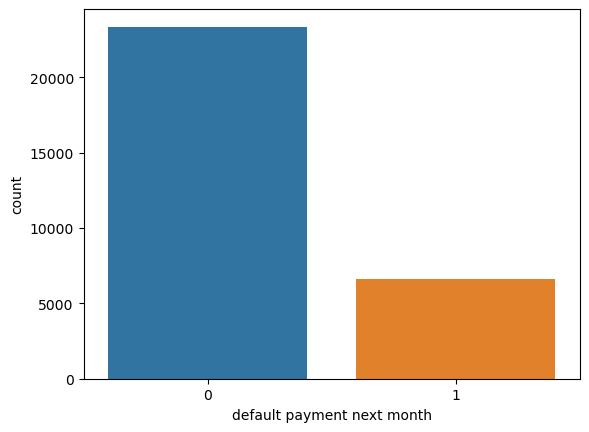

In [31]:
sns.countplot(x='default payment next month', data=df)

## Bi-variate Analysis

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def bivariate_plot(df, feature, target='default payment next month', bins=10):
    """
    Creates a bivariate plot: clustered bar (Goods, Bads) + line chart (% Bad)
    
    Parameters:
    - df: DataFrame containing the data
    - feature: The feature column to plot against the binary target
    - target: Binary target column (1 = bad, 0 = good)
    - bins: Number of bins for numeric variables
    """
    temp_df = df.copy()

    if pd.api.types.is_numeric_dtype(temp_df[feature]):
        # Bin the numeric variable into quantiles
        temp_df['bin'] = pd.qcut(temp_df[feature], q=bins, duplicates='drop')
    else:
        temp_df['bin'] = temp_df[feature]

    # Group by bin and calculate stats
    summary = temp_df.groupby('bin')[target].agg(
        Bads='sum',
        Count='count'
    )
    summary['Goods'] = summary['Count'] - summary['Bads']
    summary['Bad Rate (%)'] = 100 * summary['Bads'] / summary['Count']

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot: Bads and Goods
    summary[['Goods', 'Bads']].plot(kind='bar', stacked=False, ax=ax1, width=0.6)
    ax1.set_ylabel("Count")
    ax1.set_title(f"Bivariate Analysis: {feature} vs {target}")
    ax1.tick_params(axis='x', rotation=45)

    # Line chart: % Bad
    ax2 = ax1.twinx()
    ax2.plot(summary['Bad Rate (%)'].values, color='red', marker='o', linestyle='-', label='% Bad')
    ax2.set_ylabel("% Bad")
    ax2.set_ylim(0, summary['Bad Rate (%)'].max() * 1.2)

    # Show both legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper right')

    plt.tight_layout()
    plt.show()


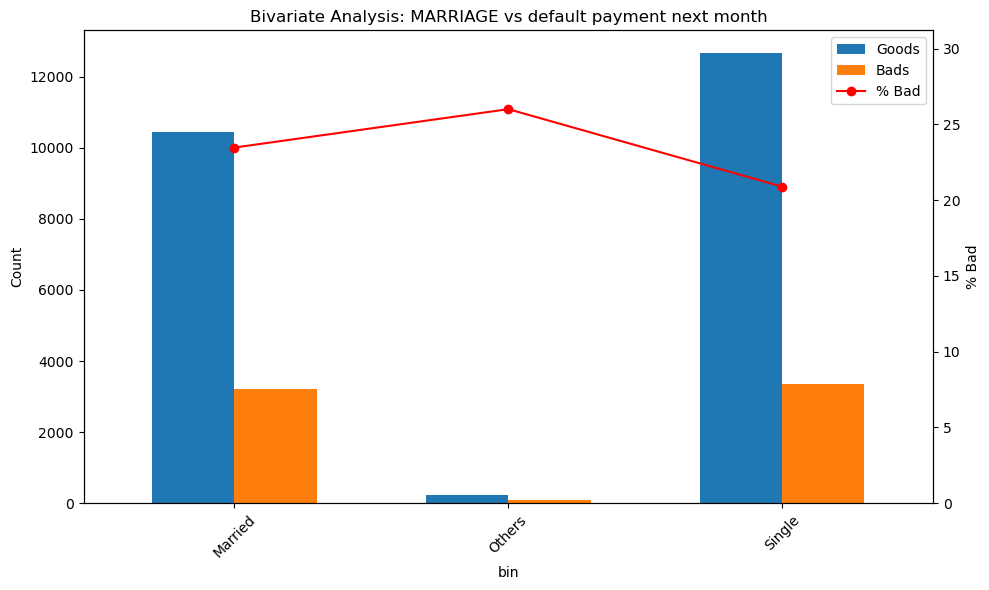

In [33]:
# For categorical variable
bivariate_plot(df, feature='MARRIAGE')

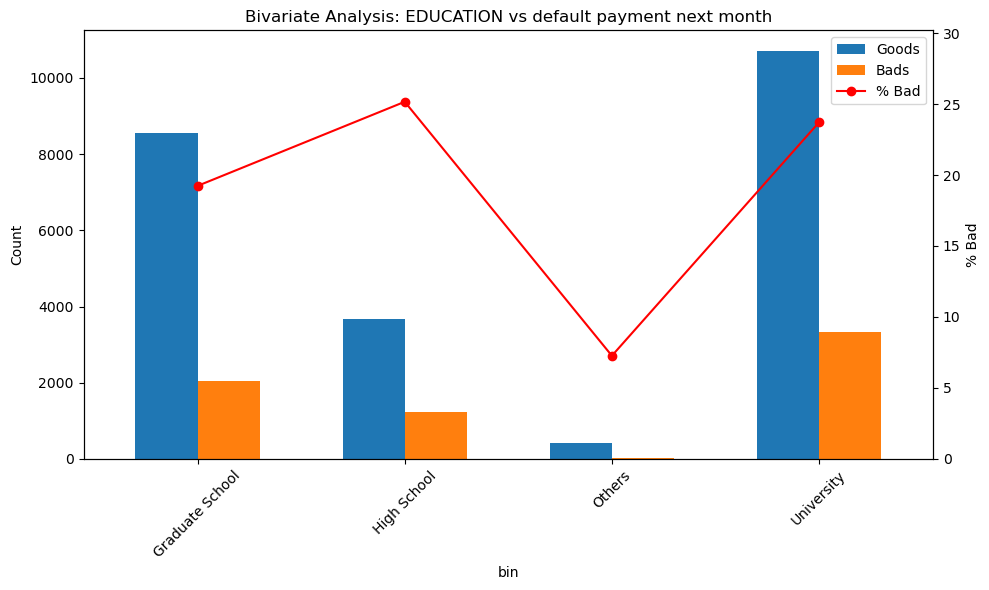

In [36]:
# For categorical variable
bivariate_plot(df, feature='EDUCATION')

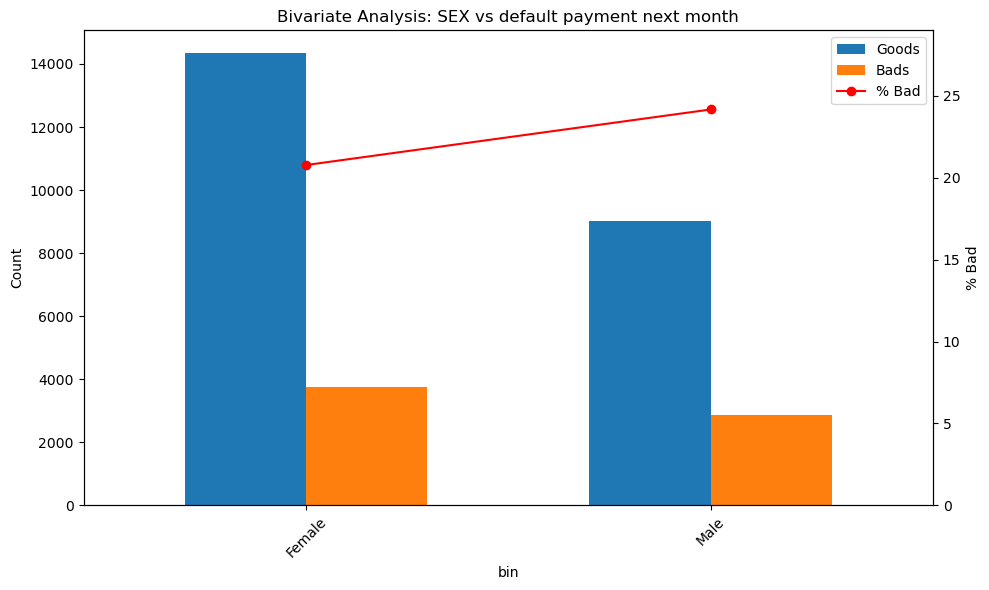

In [37]:
# For categorical variable
bivariate_plot(df, feature='SEX')

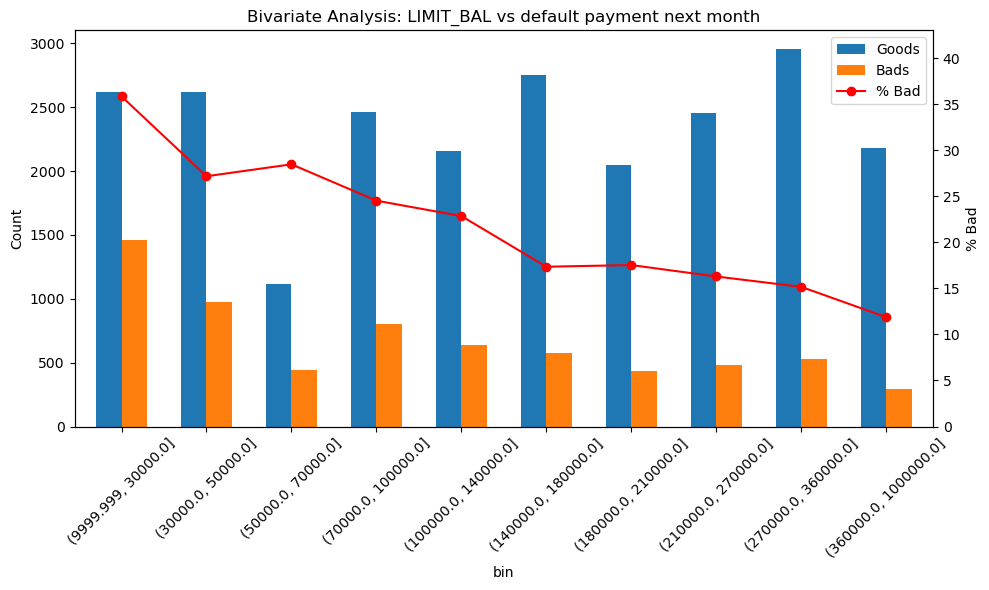

In [38]:
# For numeric variable
bivariate_plot(df, feature='LIMIT_BAL')

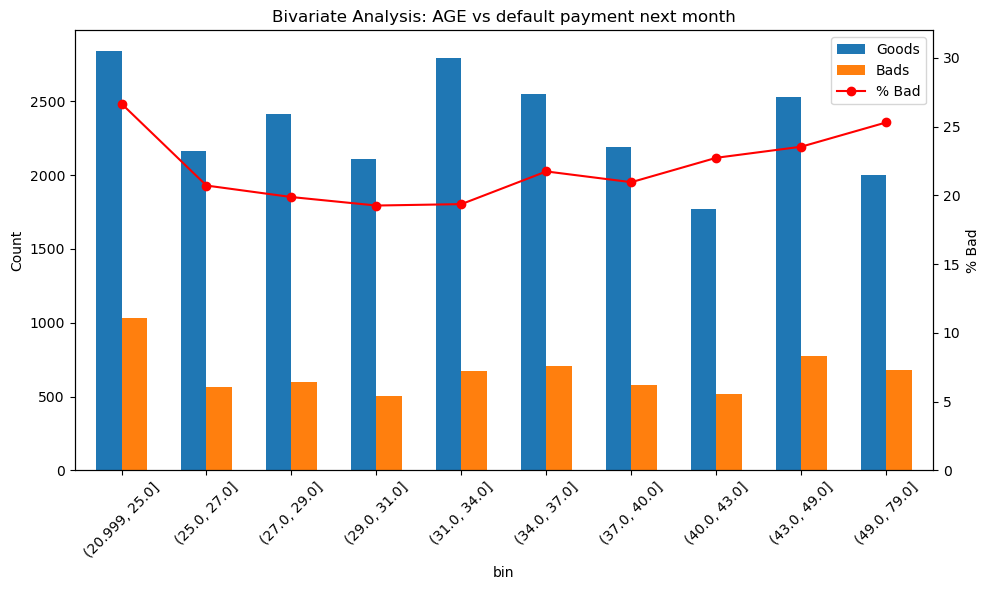

In [39]:
# For numeric variable
bivariate_plot(df, feature='AGE')

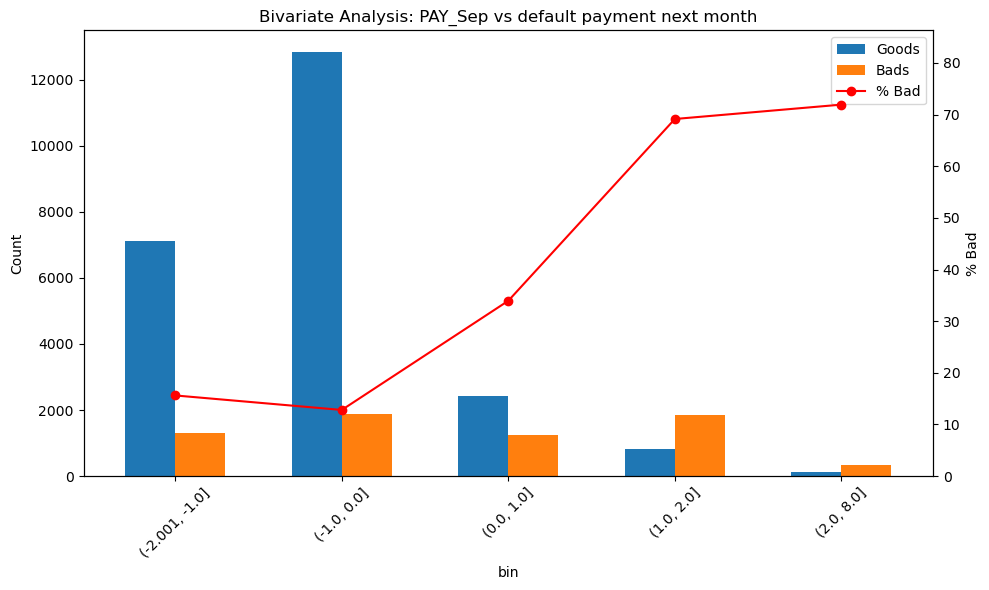

In [40]:
# For numeric variable
bivariate_plot(df, feature='PAY_Sep')

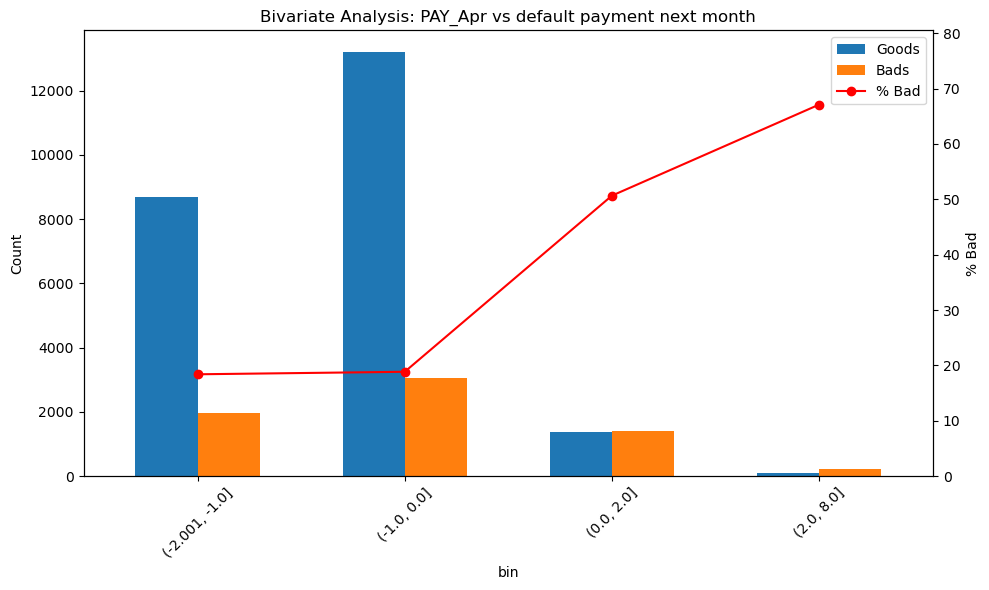

In [41]:
# For numeric variable
bivariate_plot(df, feature='PAY_Apr')

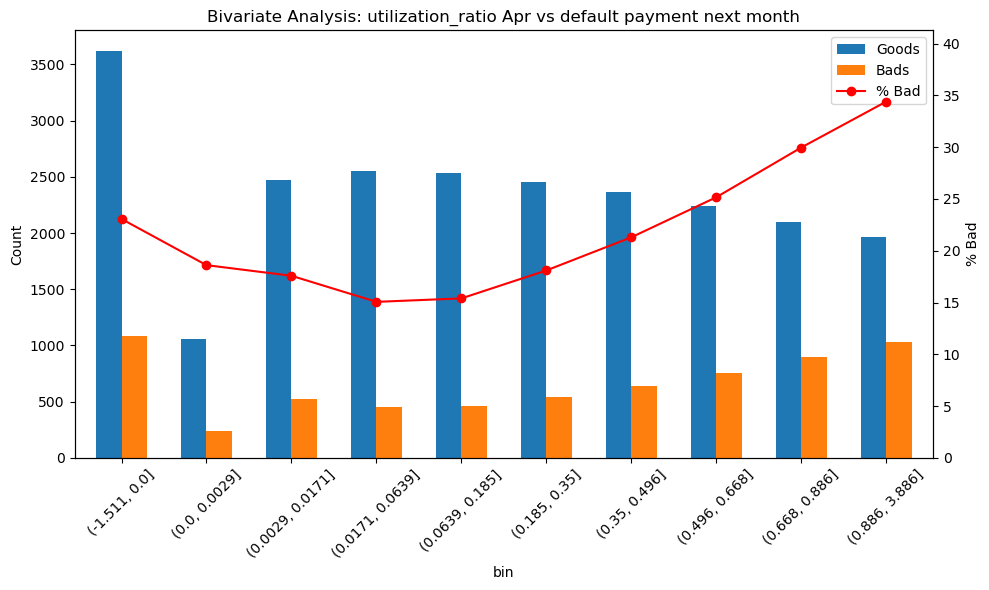

In [42]:
bivariate_plot(df,'utilization_ratio Apr')

In [ ]:
df.columns

In [ ]:
bivariate_plot(df, feature='Delinquent Aug')

In [ ]:
pd.crosstab(df['SEX'], df['default payment next month'], normalize='index').plot(kind='bar', stacked=True)

In [ ]:
sns.boxplot(x='default payment next month', y='LIMIT_BAL', data=df)

## Time Series Analysis

In [ ]:
df['PAY_Apr'].value_counts(dropna=False)

In [43]:
pay_cols = ['PAY_Apr', 'PAY_May', 'PAY_Jun', 'PAY_Jul', 'PAY_Aug', 'PAY_Sep']

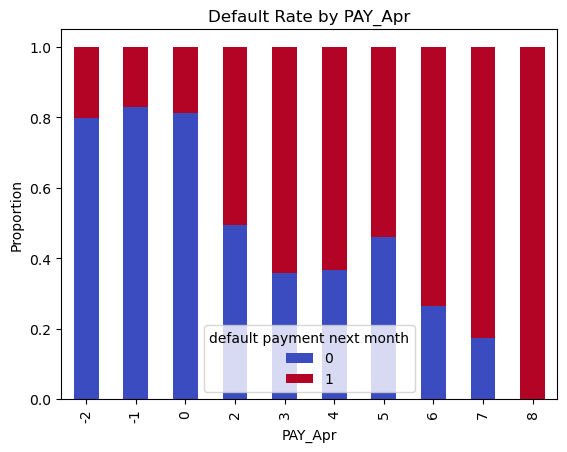

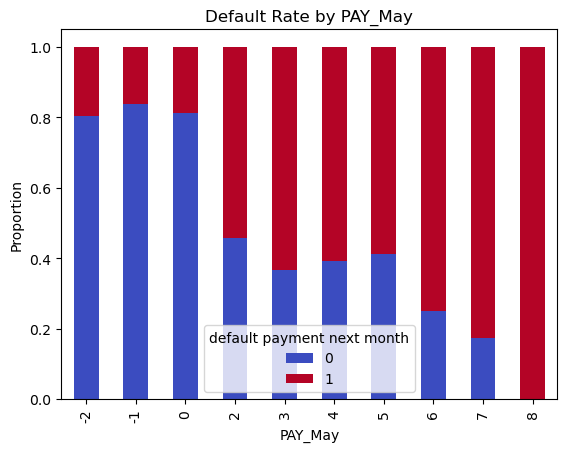

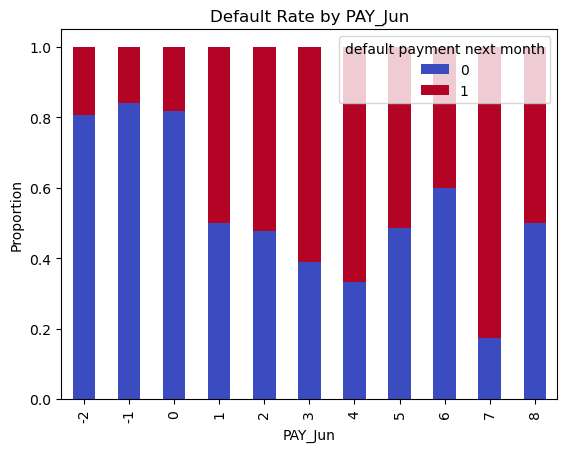

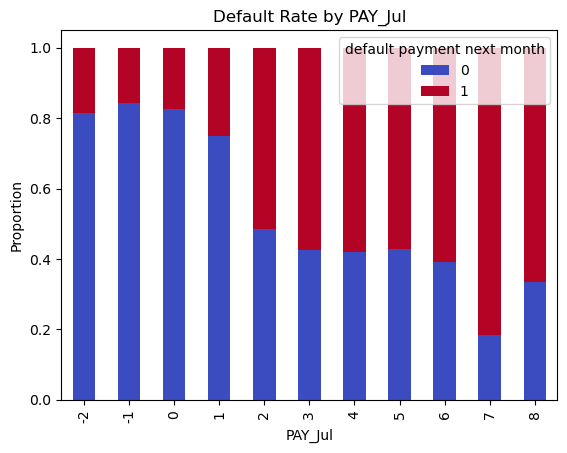

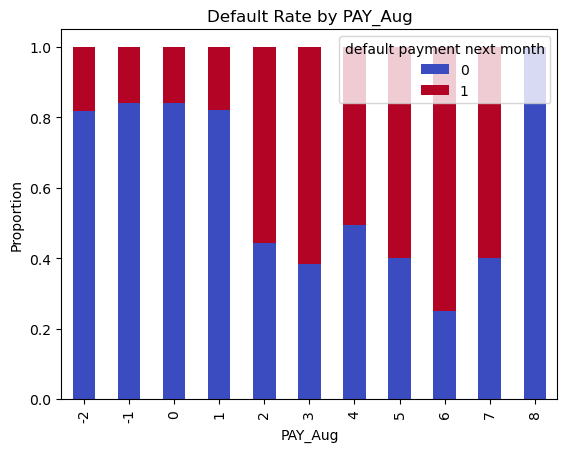

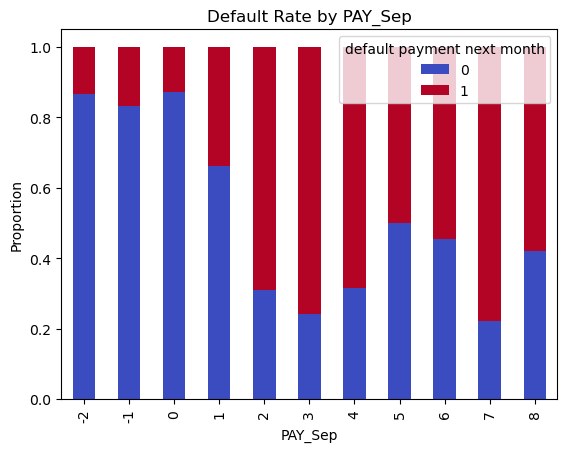

In [44]:
import matplotlib.pyplot as plt

for col in pay_cols:
    ctab = pd.crosstab(df[col], df['default payment next month'], normalize='index')
    ctab.plot(kind='bar', stacked=True, colormap='coolwarm')
    plt.title(f'Default Rate by {col}')
    plt.ylabel('Proportion')
    plt.show()


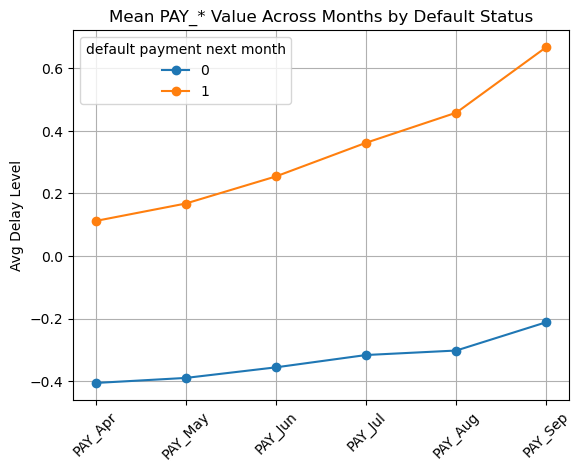

In [45]:
df.groupby('default payment next month')[pay_cols].mean().T.plot(marker='o')
plt.title('Mean PAY_* Value Across Months by Default Status')
plt.ylabel('Avg Delay Level')
plt.xticks(rotation=45)
plt.grid()


In [55]:
def categorize_pay_status(df, pay_cols):
    def categorize(value):
        if value <= 0:
            return 'Paid'
        elif value == 1:
            return 'Delayed by 1 month'
        elif value == 2:
            return 'Delayed by 2 months'
        elif value == 3:
            return 'Delayed by 3 months'
        else:  # value >= 4
            return 'Delayed by more than 3 months'
    
    for col in pay_cols:
        df[col] = df[col].apply(categorize)
    return df


In [57]:
pay_cols = ['PAY_Apr', 'PAY_May', 'PAY_Jun', 'PAY_Jul', 'PAY_Aug', 'PAY_Sep']
df = categorize_pay_status(df, pay_cols)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pay_status_vs_bad_rate_clean(df, pay_cols, target_col='default payment next month',
                                      delay_levels=None):
    """
    Cleaner version: Plots % of defaults for each PAY status over months.
    - Legend placed outside
    - Improved figure size and readability
    """

    # Automatically determine levels if not given
    if delay_levels is None:
        delay_levels = sorted(set(val for col in pay_cols for val in df[col].unique()))

    plt.figure(figsize=(14, 7))

    for delay in delay_levels:
        percent_bads = []
        for col in pay_cols:
            total = (df[col] == delay).sum()
            if total == 0:
                percent_bads.append(np.nan)
                continue
            bads = ((df[col] == delay) & (df[target_col] == 1)).sum()
            percent_bads.append(100 * bads / total)

        plt.plot(pay_cols, percent_bads, marker='o', label=f'PAY={delay}')

    plt.title('% of Defaults for each PAY Status over Months', fontsize=14)
    plt.xlabel('PAY_* Month', fontsize=12)
    plt.ylabel('% Bad', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Move legend outside the plot
    plt.legend(title='Repayment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

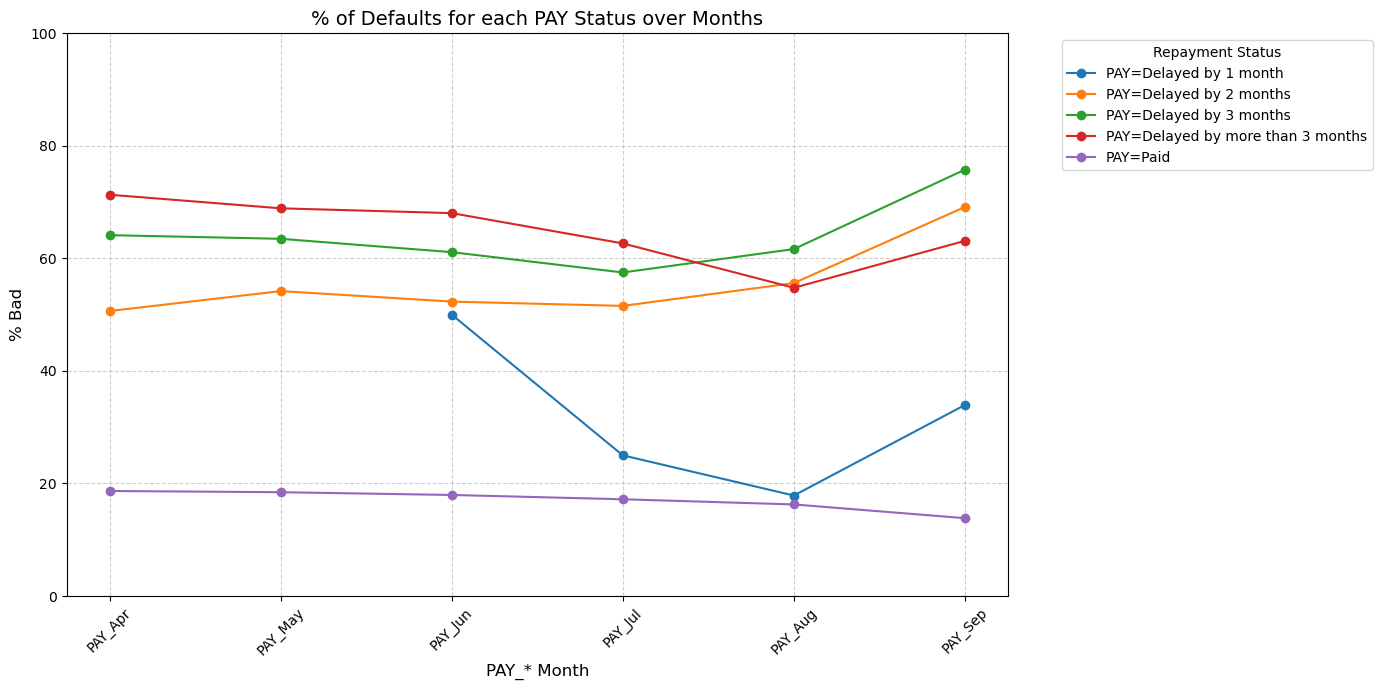

In [58]:
pay_cols = ['PAY_Apr', 'PAY_May', 'PAY_Jun', 'PAY_Jul', 'PAY_Aug', 'PAY_Sep']
plot_pay_status_vs_bad_rate_clean(df, pay_cols)